### 这个文档的作用是提取比例数据

#### 导入库

In [1]:
# -*- coding: utf-8 -*-
import requests
import time
import os
import glob
import math
import ssl
import pandas as pd
import geopandas as gpd
from requests.adapters import HTTPAdapter
import json
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [2]:
from requests.adapters import HTTPAdapter
import json
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [3]:
import re

In [30]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 

#### 提取比例
1. 提取每个类型涉及到的研学的评论数
2. 提取年龄的相关的关键词

就是每1000条评论里面有多少条评论提到研学相关的评论数量，就是一个比值。我最后要用这个数据来统计汇总， 全国的哪些城市它去玩的人人提到的研学的比例是最高的，然后哪一类的景区他提到的研学的比例是更高的，用来替代我们之前所设计的联通数据。如果数据里面有。。岁，小学，初中，高中这样表达年龄的数据也提出来，看一下比例

In [31]:
comments_df = pd.read_csv('df_all.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_75844\1204374322.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('df_all.csv', encoding='utf-8-sig')


In [32]:
comments_df = comments_df.drop_duplicates(subset="commentId", keep="first")

In [33]:
comments_df.shape

(1193541, 17)

In [34]:
comments_df = comments_df.drop_duplicates(subset="commentId", keep="first")

#### 提取类别的关键词

In [35]:
study_keywords = ['研学',"研学旅行", "研学团", "研学活动", "研学营", "研学基地", 
    "学生团", "学校组织", "带孩子来学习", "寓教于乐", "教育基地",'学习', '教育', '学校', '学生','营地','银发','夏令营','冬令营'] # 意思是：包含"研学" OR "学习" OR "教育" OR "学校" OR "学生" #

age_keywords = {
    "小学": ["小学", "小学生"],
    "初中": ["初中", "初中生", "初一", "初二", "初三"],
    "高中": ["高中", "高中生", "高一", "高二", "高三"],
    "大学": ["大学生", "本科", "研究生","大一","大二","大三","大四","大五"]
}

##### 构造函数

In [36]:
def is_study_related(text):
    return any(kw in text for kw in study_keywords)

def extract_age_group(text):
    if not isinstance(text, str):
        return None  # 避免非字符串报错
    matches = []  # ✅ 提前定义列表
    for age_group, kws in age_keywords.items():
        for kw in kws:
            # 构建词边界匹配模式（确保匹配完整词语）
            pattern =  re.escape(kw)
            if re.search(pattern, text):
                matches.append((age_group, kw))
    if not matches:
        return None
    # 长词优先（防止“高”比“高中”先匹配）
    matches.sort(key=lambda x: len(x[1]), reverse=True)
    return matches[0][0]

#### 计算筛选出研学和各个年龄阶段

In [37]:
import re
study_pattern = re.compile("|".join(study_keywords))
comments_df["is_study"] = comments_df["content"].str.contains(study_pattern, na=False)

In [38]:
study_comments = comments_df["is_study"].sum()
study_comments

33639

##### 提取所有研学评论中的年龄

In [39]:
study_df = comments_df[comments_df["is_study"] == True].copy()

In [40]:
study_df["age_group"] = study_df["content"].apply(extract_age_group)

In [ ]:
# study_df.to_excel(".\data\研学信息表1.xlsx", index=False)

#### 计算需要的相关的比例

In [39]:
ratio_by_attraction = (
    comments_df.groupby("poi_type")["is_study"]
    .mean()
    .reset_index(name="study_ratio")
)
ratio_by_attraction["study_per_1000"] = ratio_by_attraction["study_ratio"] * 1000

In [40]:
ratio_by_attraction

,poi_type,study_ratio,study_per_1000
0,体验考察型,0.033724,33.723607
1,励志拓展型,0.147965,147.965406
2,文化康乐型,0.006389,6.388886
3,知识科普型,0.031710,31.709690
4,自然观赏型,0.006707,6.706794


In [41]:
ratio_by_subtype = (
    comments_df.groupby("poi_subtype")["is_study"]
    .mean()
    .reset_index(name="study_ratio")
)
ratio_by_subtype["study_per_1000"] = ratio_by_subtype["study_ratio"] * 1000

In [42]:
ratio_by_subtype

,poi_subtype,study_ratio,study_per_1000
0,农庄,0.010221,10.221205
1,动物园,0.010949,10.948974
2,博物馆,0.042256,42.256124
3,历史文化遗产,0.014723,14.723263
4,国家公园,0.005155,5.154768
5,国防教育,0.473684,473.684211
6,夏令营,0.500000,500.000000
7,大学,0.153100,153.099506
8,实践基地,0.014726,14.725569
9,工业遗产,0.065056,65.055762


In [43]:
ratio_by_city = (
    comments_df.groupby("city")["is_study"]
    .mean()
    .reset_index(name="study_ratio")
)
ratio_by_city["study_per_1000"] = ratio_by_city["study_ratio"] * 1000
ratio_by_city

,city,study_ratio,study_per_1000
0,上海,0.039985,39.985346
1,云南,0.020005,20.004713
2,内蒙古,0.029874,29.873748
3,北京,0.043639,43.639053
4,台湾,0.030431,30.431107
5,吉林,0.017906,17.906022
6,四川,0.028065,28.064820
7,天津,0.037321,37.321016
8,宁夏,0.012811,12.811309
9,安徽,0.018926,18.926196


In [44]:
ratio_by_city.to_csv("./data/city_study_ratio.csv", index=False)
ratio_by_attraction.to_csv("./data/attraction_study_ratio.csv", index=False)

##### 年龄的计算

In [45]:
age_distribution = (
    study_df
    .groupby("age_group")
    .size()
    .reset_index(name="count")
)
age_distribution["age_ratio"] = age_distribution["count"] / age_distribution["count"].sum()

In [46]:
age_distribution

,age_group,count,age_ratio
0,初中,102,0.027449
1,大学,2163,0.582078
2,小学,1378,0.370829
3,高中,73,0.019645


In [47]:
# 不同类型的年龄比例
age_by_type = (
    study_df
    .groupby(["poi_type", "age_group"])
    .size()
    .reset_index(name="count")
)
age_by_type["age_ratio"] = (
    age_by_type["count"] / age_by_type.groupby("poi_type")["count"].transform("sum")
)
age_by_type

,poi_type,age_group,count,age_ratio
0,体验考察型,大学,10,0.370370
1,体验考察型,小学,15,0.555556
2,体验考察型,高中,2,0.074074
3,励志拓展型,初中,3,0.002013
4,励志拓展型,大学,1472,0.987919
5,励志拓展型,小学,11,0.007383
6,励志拓展型,高中,4,0.002685
7,文化康乐型,初中,1,0.016667
8,文化康乐型,大学,25,0.416667
9,文化康乐型,小学,31,0.516667


In [48]:
# 不同省份的年龄比例
age_by_city = (
    study_df
    .groupby(["city", "age_group"])
    .size()
    .reset_index(name="count")
)
age_by_city["age_ratio"] = (
    age_by_city["count"] / age_by_city.groupby("city")["count"].transform("sum")
)
age_by_city

,city,age_group,count,age_ratio
0,上海,初中,6,0.014815
1,上海,大学,140,0.345679
2,上海,小学,252,0.622222
3,上海,高中,7,0.017284
4,云南,初中,1,0.019608
...,...,...,...,...
110,香港,高中,1,0.076923
111,黑龙江,初中,1,0.028571
112,黑龙江,大学,29,0.828571
113,黑龙江,小学,4,0.114286


In [49]:
age_dist_city_type = (
    study_df
    .groupby(["city", "poi_type", "age_group"])
    .size()                             # 每个组合下的评论数
    .reset_index(name="count")          # 生成列名
)

In [50]:
age_dist_city_type

,city,poi_type,age_group,count
0,上海,励志拓展型,大学,80
1,上海,励志拓展型,高中,1
2,上海,文化康乐型,大学,2
3,上海,文化康乐型,小学,1
4,上海,知识科普型,初中,6
...,...,...,...,...
218,黑龙江,知识科普型,大学,24
219,黑龙江,知识科普型,小学,3
220,黑龙江,知识科普型,高中,1
221,黑龙江,自然观赏型,大学,1


In [51]:
age_dist_city_type["age_ratio"] = (
    age_dist_city_type["count"] / 
    age_dist_city_type.groupby(["city", "poi_type"])["count"].transform("sum")
)
age_dist_city_type

,city,poi_type,age_group,count,age_ratio
0,上海,励志拓展型,大学,80,0.987654
1,上海,励志拓展型,高中,1,0.012346
2,上海,文化康乐型,大学,2,0.666667
3,上海,文化康乐型,小学,1,0.333333
4,上海,知识科普型,初中,6,0.018692
...,...,...,...,...,...
218,黑龙江,知识科普型,大学,24,0.827586
219,黑龙江,知识科普型,小学,3,0.103448
220,黑龙江,知识科普型,高中,1,0.034483
221,黑龙江,自然观赏型,大学,1,0.500000


In [52]:
age_by_type.to_csv("./data/age_ratio_by_type.csv", index=False)
age_by_city.to_csv("./data/age_ratio_by_city.csv", index=False)
age_dist_city_type.to_csv("./data/age_ratio_by_city_type.csv", index=False)

#### 相关的分析

In [76]:
total_df = pd.read_csv('./data/研学数据分析/研学信息表总表.csv', encoding='utf-8-sig')
primary_df = pd.read_csv('./data/研学数据分析/小学阶段.csv', encoding='utf-8-sig')
middle_df = pd.read_csv('./data/研学数据分析/初中阶段.csv', encoding='utf-8-sig')
high_df = pd.read_csv('./data/研学数据分析/高中阶段.csv', encoding='utf-8-sig')
graduate_df = pd.read_csv('./data/研学数据分析/大学阶段.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_75844\3901545283.py:1: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data/研学数据分析/研学信息表总表.csv', encoding='utf-8-sig')


全局设置变量

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

In [69]:
# 全局设置
sns.set(style="whitegrid")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=sns.color_palette("Blues", 6))

# 假期与季节标签
month_labels = ["1月", "2月", "3月", "4月", "5月", "6月", "7月", "8月", "9月", "10月", "11月", "12月"]
seasons = ["冬", "冬", "春", "春", "春", "夏", "夏", "夏", "秋", "秋", "秋", "冬"]
holidays = ["寒假", "寒假", "", "", "五一", "", "暑假", "暑假", "", "十一", "", ""]

# 为季节设置颜色
season_colors = {
    "春": "#65C8AB",  # 柔和新绿
    "夏": "#0D5018",  # 淡黄
    "秋": "#B5C75F",  # 浅橙
    "冬": "#4E7DB0",  # 冬季淡蓝
}

In [100]:
def plot_monthly_trend(data, stage_name, gap=4):
    df = data
    freq = df.groupby("月份").size().reindex(range(1, 13), fill_value=0).reset_index(name="评论数")

    fig, ax = plt.subplots(figsize=(12, 6))

    # ==== 1. 准备折线数据 ====
    x = freq["月份"].values
    y = freq["评论数"].values

    # ==== 2. 沿折线形状填充（按季节分段） ====
    for i in range(len(x) - 1):
        m1, m2 = x[i], x[i + 1]
        y1, y2 = y[i], y[i + 1]
        s1 = seasons[m1 - 1]
        s2 = seasons[m2 - 1]

        # 若两个点属于同一个季节，就填充这一段
        if s1 == s2:
            ax.fill_between(
                [m1, m2],
                [y1, y2],
                [0, 0],
                color=season_colors[s1],
                alpha=0.25,
                zorder=0
            )
        else:
            # 如果跨季节，就分成两个0.5切开处理
            mid = (m1 + m2) / 2
            ax.fill_between(
                [m1, mid],
                [y1, (y1 + y2) / 2],
                [0, 0],
                color=season_colors[s1],
                alpha=0.25,
                zorder=0
            )
            ax.fill_between(
                [mid, m2],
                [(y1 + y2) / 2, y2],
                [0, 0],
                color=season_colors[s2],
                alpha=0.25,
                zorder=0
            )

    # ==== 3. 假期叠加斜线 ====
    for month in range(1, 13):
        if holidays[month - 1]:
            ax.axvspan(
                month - 0.5, month + 0.5,
                facecolor="none",
                edgecolor="grey",
                hatch='///',
                linewidth=0,
                alpha=0.3,
                zorder=1
            )

    # ==== 4. 折线图 ====
    sns.lineplot(
        x="月份",
        y="评论数",
        data=freq,
        marker="o",
        linewidth=2.5,
        color="#3F80C1",
        ax=ax,
        zorder=2
    )

    # ==== 5. 添加数值注释 ====
    # for i, row in freq.iterrows():
    #     ax.text(row["月份"], row["评论数"] + gap, str(row["评论数"]),
    #             ha='center', va='bottom', fontsize=9,
    #             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
    #             zorder=3)

    # ==== 6. x轴标签 ====
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([
        f"{m}\n({seasons[m-1]}{'·' + holidays[m-1] if holidays[m-1] else ''})"
        for m in range(1, 13)
    ])

    # ==== 7. 其他设置 ====
    ax.set_title(f"{stage_name}阶段研学月度分布趋势", fontsize=15)
    ax.set_ylabel("数量")
    ax.set_xlabel("月份（季节·假期）")
    ax.set_ylim(bottom=0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    # ==== 8. 图例 ====
    legend_patches = [
        mpatches.Patch(color=color, alpha=0.4, label=season)
        for season, color in season_colors.items()
    ]
    ax.legend(handles=legend_patches, title="季节背景色", loc="upper left")

    plt.tight_layout()
    plt.show()

In [177]:
from matplotlib import cm
blues_11 = [
    "#d6eaf8",  # 浅蓝（偏灰白，顶部）
    "#aed6f1",  # 淡蓝
    "#85c1e9",  # 亮蓝
    "#5dade2",  # 中亮蓝
    "#3498db",  # 主蓝色
    "#2e86c1",  # 稍深蓝
    "#2874a6",  # 正蓝色
    "#21618c",  # 靛蓝过渡
    "#1b4f72",  # 深蓝
    "#154360",  # 靛青
    "#0e3a5e"   # 极深蓝（底部）
]


In [197]:
def plot_top_province_poi_stacked(data, stage_name):
    df = data.copy()

    # Step 1: 统计每个 city 的评论数量（即评论总数）
    city_comment_counts = df.groupby("city").size().sort_values(ascending=False)

    # Step 2: 获取评论数最多的前 5 个城市
    top5_cities = city_comment_counts.head(5).index

    # Step 3: 筛选出这5个城市的数据
    df_top5 = df[df["city"].isin(top5_cities)]

    # Step 4: 统计每个城市下，不同 POI 子类型的评论数量
    grouped = df_top5.groupby(["city", "poi_subtype"]).size().unstack(fill_value=0)

    # Step 5: 保持城市顺序（按照 top5_cities 顺序）
    grouped = grouped.loc[top5_cities]

    # ✅ Step 6: 导出为 CSV（可用于 Excel 制图）
    output_filename = f"./data/研学数据分析/{stage_name}_top5城市_POI堆叠图数据.csv"
    grouped.to_csv(output_filename, encoding='utf-8-sig')  # 用 utf-8-sig 保证 Excel 正常打开中文
    # Step 6: 绘制堆叠条形图
    grouped.plot(kind="bar", stacked=True, color=blues_11[:len(grouped.columns)], figsize=(10, 6))

    plt.title(f"{stage_name}阶段研学热点省份与场所分布", fontsize=14)
    plt.xlabel("省份")
    plt.ylabel("数量")
    plt.xticks(rotation=0)
    plt.legend(title="场所类型", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### 不同年龄阶段数据出图

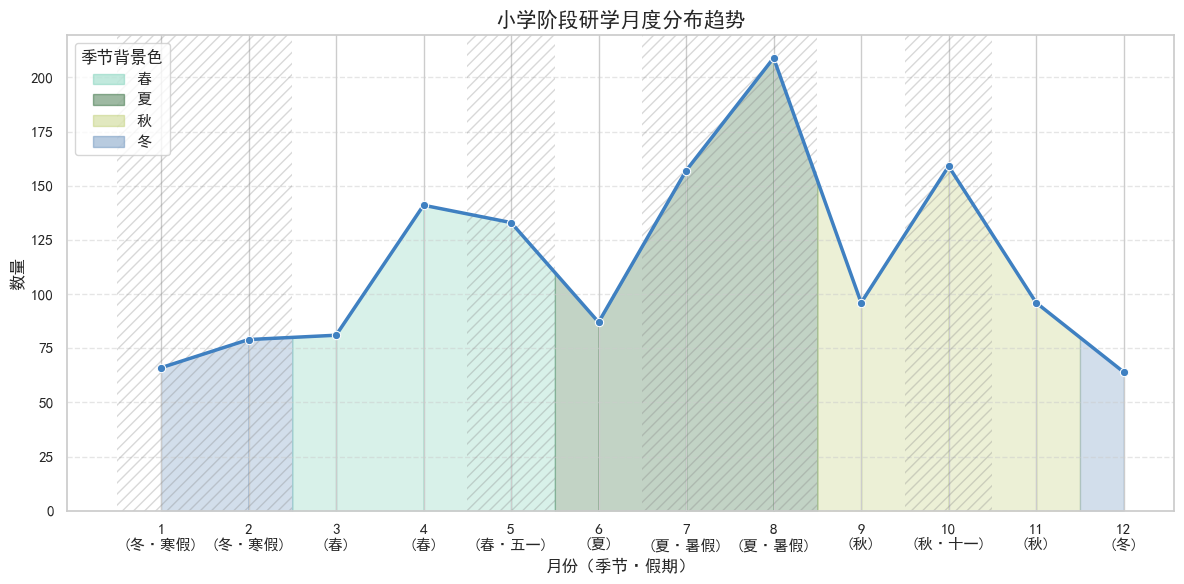

In [101]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 
plot_monthly_trend(primary_df, "小学")

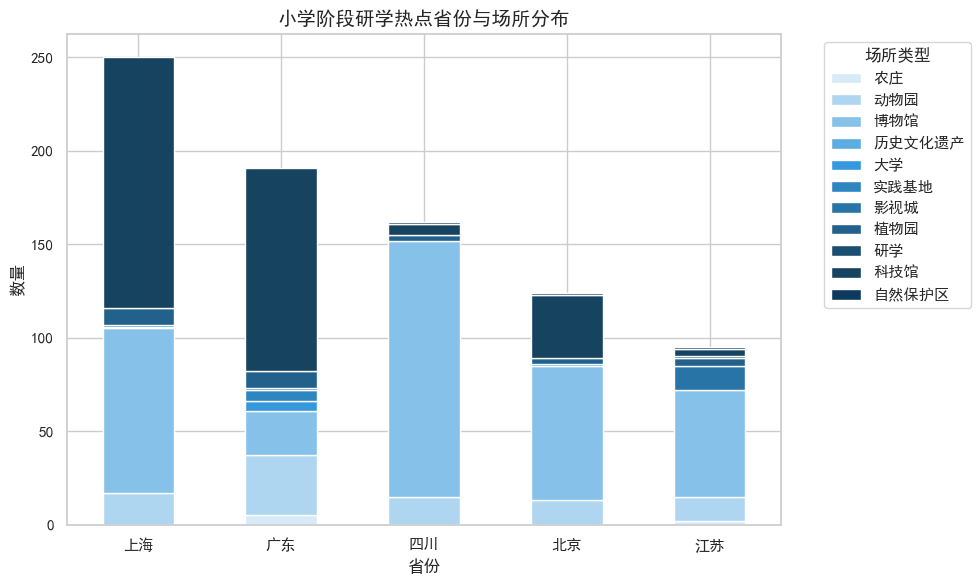

In [198]:
plot_top_province_poi_stacked(primary_df, "小学")

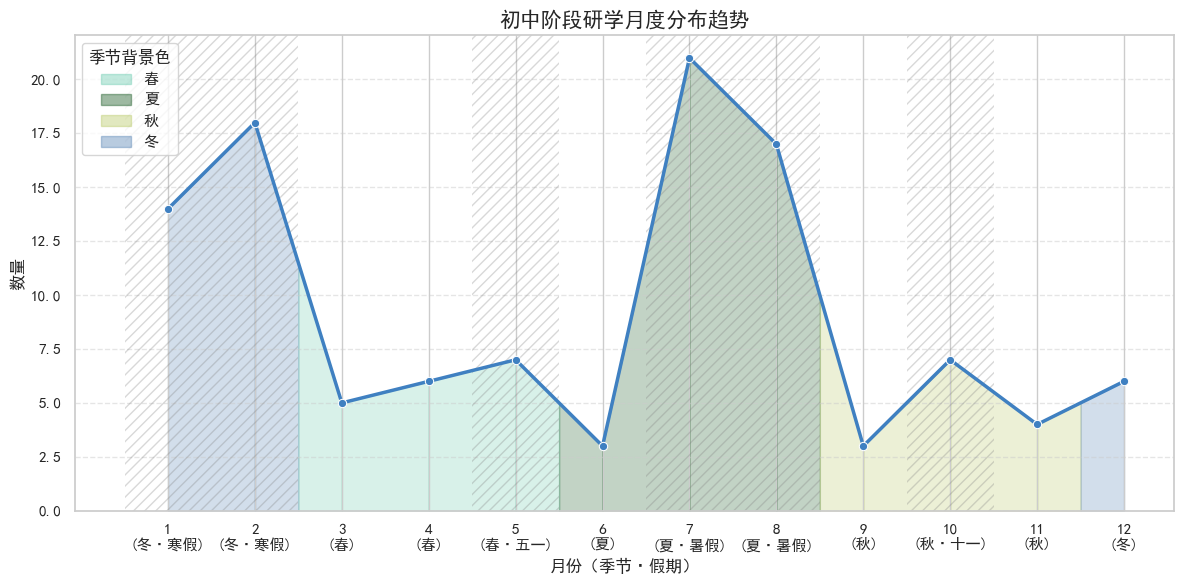

In [103]:
plot_monthly_trend(middle_df, "初中",gap=0.5)


In [ ]:
plot_top_province_poi_stacked(middle_df, "初中")

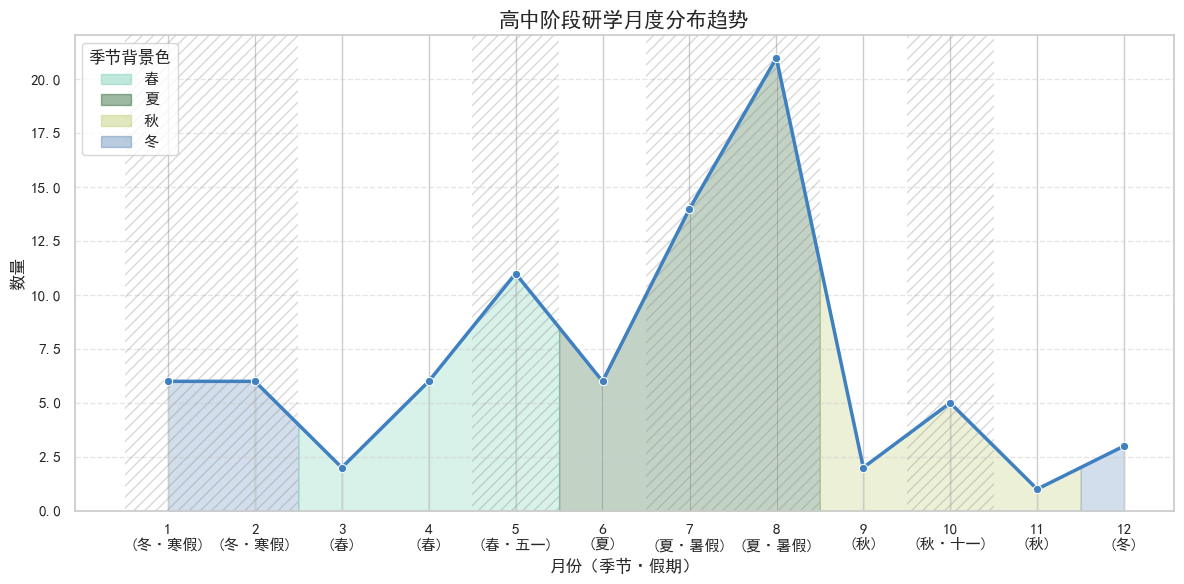

In [104]:
plot_monthly_trend(high_df, "高中",gap=0.5)


In [ ]:
plot_top_province_poi_stacked(high_df, "高中")

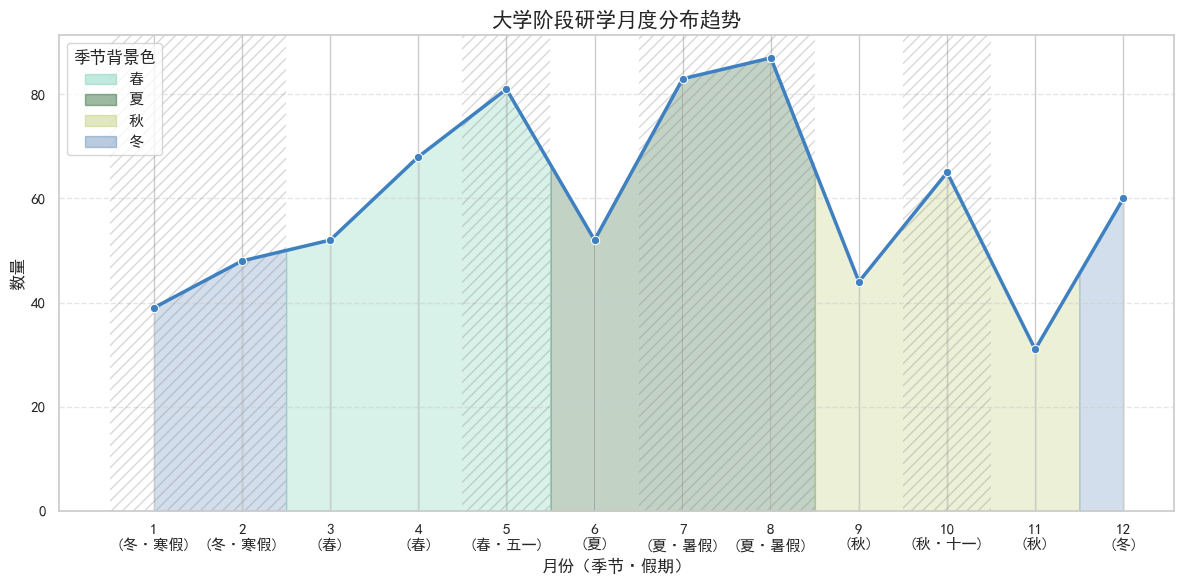

In [105]:
plot_monthly_trend(graduate_df, "大学",gap=0.5)

In [ ]:
plot_top_province_poi_stacked(graduate_df, "大学")

In [91]:
def prepare_texts_basic(df, stopwords_path, min_length=5):
    """
    基础文本处理：分词 + 停用词过滤 + 长度过滤 + 保留 commentId 对应关系
    返回值：
        texts_cut: [(commentId, [分词结果])]
        共 N 条有效评论
    """

    # 加载停用词
    with open(stopwords_path, "r", encoding="utf-8") as f:
        stopwords = set(w.strip() for w in f if w.strip())

    # 分词 + 停用词过滤
    texts_cut = []
    for cid, text in zip(df["commentId"], df["content"].astype(str)):
        words = [
            w for w in jieba.cut(text)
            if w not in stopwords and len(w) > 1 and not w.isdigit() #1
        ]
        if len(words) >= min_length:
            texts_cut.append((cid, words))  # ✅ 保留 commentId

    print(f"已完成分词与过滤，共 {len(texts_cut)} 条有效评论")
    return texts_cut

In [ ]:
def generate_wordcloud(docs,output_dir="./lda_results",
                       font_path="msyh.ttc", max_words=200, cmap="Blues_r", random_state=42):

    if not docs:
        print("⚠️ 输入 tokenized_docs 为空，跳过词云生成。")
        return None

    os.makedirs(output_dir, exist_ok=True)

    # 将二维分词结果拼接为一个整体字符串
    all_words = " ".join([" ".join([str(w) for w in words]) for words in docs])

    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        width=1000,
        height=600,
        colormap=cmap,
        max_words=max_words,
        random_state=random_state
    ).generate(all_words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"研学评论词云", fontsize=14)
    save_path = os.path.join(output_dir, f"study_wordcloud.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ 词云已保存至: {save_path}")
    return wc

##### 词云

已完成分词与过滤，共 1196 条有效评论


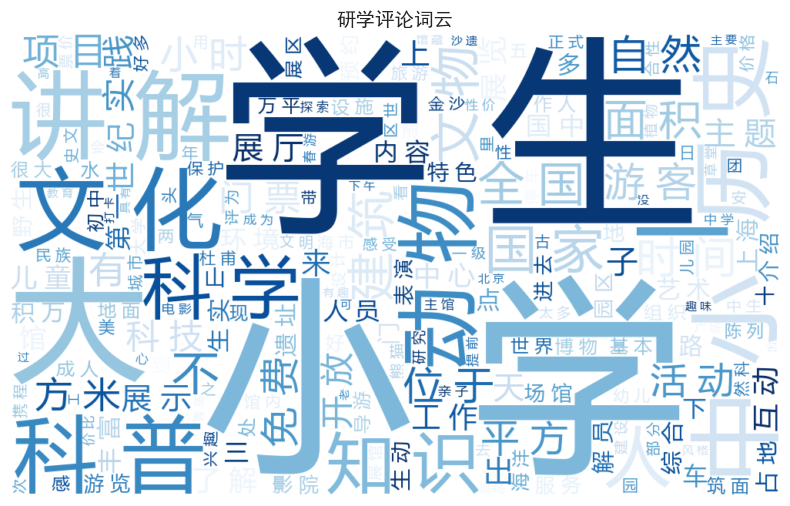

✅ 词云已保存至: ./lda_results\study_wordcloud.png


In [196]:
primary_texts = prepare_texts_basic(df= primary_df, stopwords_path='./study_stopwords.txt')
primary_texts_body = [" ".join(words) for _, words in primary_texts]
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 
generate_wordcloud(primary_texts_body)

#### 绘制一下比例关系

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 

In [4]:
city_code =  pd.read_csv('city_id.csv', encoding='utf-8-sig')
city_sp = gpd.read_file('中国_省.geojson')
city_rate =  pd.read_csv('./data/city_rate.csv', encoding='utf-8-sig')

In [5]:
# 合并好评率数据
city_code_with_rating = pd.merge(city_code, city_rate, 
                                left_on='city_name',  # city_code中的城市名列
                                right_on='city',      # wide_df中的城市名列
                                how='left')
print("\ncity_sp列名:", city_sp.columns.tolist())
print("city_code列名:", city_code_with_rating.columns.tolist())


city_sp列名: ['name', 'gb', 'geometry']
city_code列名: ['city_name', 'city_ename', 'city_id', 'city_code', 'gb', 'Unnamed: 0', 'city', '研学评论比例', '每1000条评论中研学评论数量']


In [6]:
city_sp['gb'] = city_sp['gb'].astype(str)
city_code_with_rating['gb'] = city_code_with_rating['gb'].astype(str)
merged_data = city_sp.merge(city_code_with_rating, 
                           left_on='gb', 
                           right_on='gb', 
                           how='left')

print("合并完成！")
print(f"总省份数: {len(merged_data)}")

合并完成！
总省份数: 42


In [ ]:
merged_data

In [8]:
# 设置输出路径
output_geojson = "./data/游学涉及的比例.geojson"

# 保存为GeoJSON文件
merged_data.to_file(output_geojson, driver='GeoJSON', encoding='utf-8')

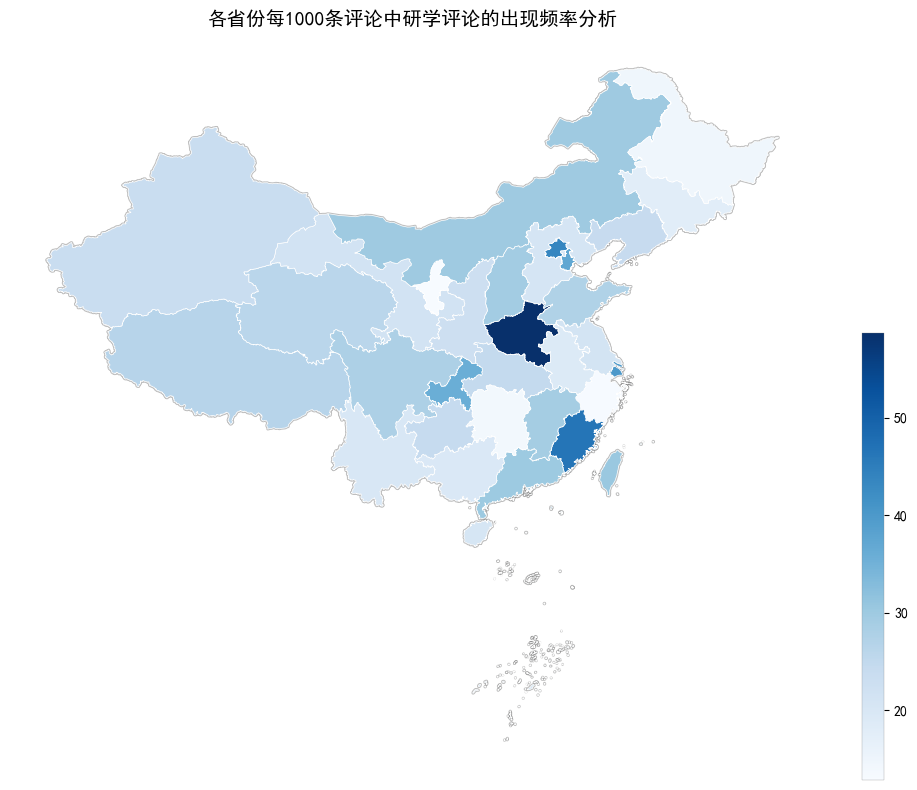

In [22]:
# 绘图
china_outline = merged_data.dissolve()
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
china_outline.plot(ax=ax, color='none', edgecolor='grey', linewidth=2, alpha=0.5)
merged_data.plot(
    column="每1000条评论中研学评论数量",
    cmap="Blues",
    linewidth=0.5,
    edgecolor="white",
    legend= False,
    ax=ax
)
# 手动添加 colorbar（右下角，缩小）
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(
    vmin=merged_data["每1000条评论中研学评论数量"].min(),
    vmax=merged_data["每1000条评论中研学评论数量"].max()
))
sm._A = []  # 兼容旧版Matplotlib
cbar = fig.colorbar(sm, ax=ax, fraction=0.02, pad=0.04, shrink=0.6, anchor=(1, 0))
# bar.set_label("每1000条评论中研学评论数量")
cbar.outline.set_edgecolor("grey")
cbar.outline.set_linewidth(0.2)
# 调整 colorbar 位置（右下角）
cbar.ax.set_position([0.88, 0.12, 0.012, 0.15]) # [left, bottom, width, height]

ax.set_title("各省份每1000条评论中研学评论的出现频率分析", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

#### 家庭亲子游学分析

In [55]:
total_df = pd.read_csv('./data/研学数据分析/研学信息表总表.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_75844\248132086.py:1: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data/研学数据分析/研学信息表总表.csv', encoding='utf-8-sig')


In [56]:
total_df.shape

(33639, 18)

In [64]:
family_df = total_df[total_df['touristTypeDisplay'] == '家庭亲子'].copy()

In [67]:
family_df['publish_date'] = pd.to_datetime(family_df['publish_date'])
family_df['月份'] = family_df['publish_date'].dt.month
freq_month = (
    family_df.groupby("月份")
      .size()
      .reindex(range(1, 13), fill_value=0)
      .reset_index(name="评论数")
)
freq_month

,月份,评论数
0,1,591
1,2,953
2,3,405
3,4,667
4,5,896
5,6,619
6,7,1606
7,8,2031
8,9,501
9,10,786


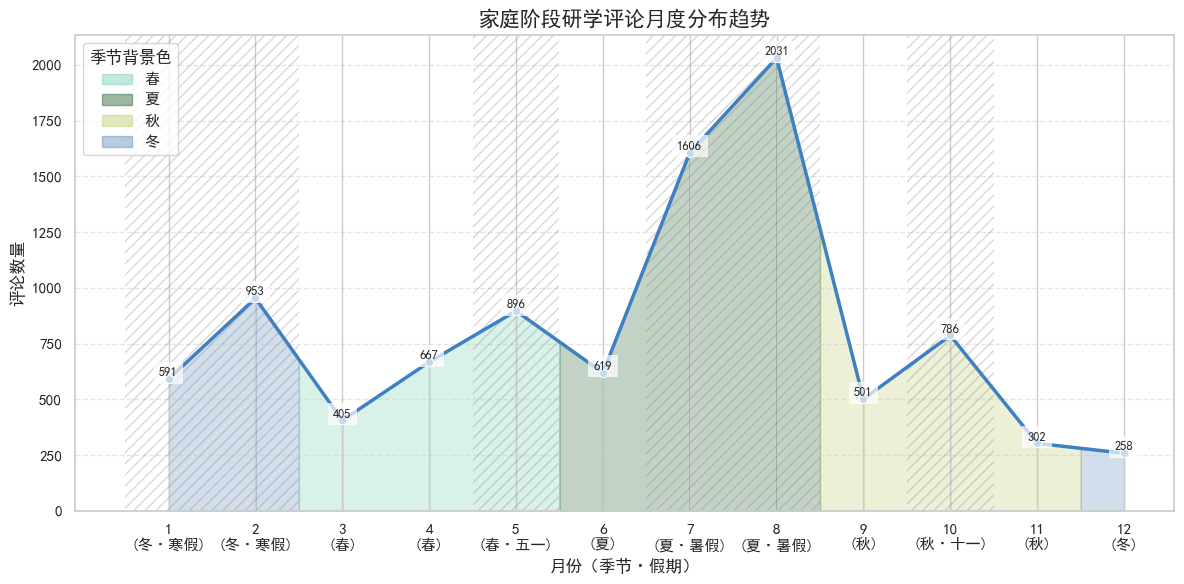

In [73]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 
plot_monthly_trend(family_df, "家庭")

In [74]:
freq_poi_name = (
    family_df.groupby("poi_name")
      .size()
      .reset_index(name="出现次数")
      .sort_values(by="出现次数", ascending=False)
)
freq_poi_name.head(20)

,poi_name,出现次数
32,上海天文馆,296
368,广东科学中心,248
113,中国科学技术馆,245
425,故宫博物院,219
475,杜甫草堂,209
235,厦门科技馆,203
90,中国地质博物馆,203
416,成都自然博物馆,176
277,国家海洋博物馆,147
117,中国航海博物馆,143


In [75]:
freq_poi_name = (
    family_df.groupby("poi_subtype")
      .size()
      .reset_index(name="出现次数")
      .sort_values(by="出现次数", ascending=False)
)
freq_poi_name.head(20)

,poi_subtype,出现次数
2,博物馆,5745
15,科技馆,1584
1,动物园,965
11,植物园,436
17,自然保护区,190
9,影视城,158
4,国家公园,147
3,历史文化遗产,117
6,大学,105
14,研学,43


In [83]:
freq_poi_name = (
    family_df.groupby("timeDuration")
      .size()
      .reset_index(name="出现次数")
      .sort_values(by="出现次数", ascending=False)
)
freq_poi_name.head(20)

,timeDuration,出现次数
4,2小时,822
7,3小时,805
8,4小时,386
9,5小时,187
1,1小时,170
2,1小时内,123
0,1天,101
10,6小时,81
11,7小时,20
6,3天以上,16


年龄的占比和比例

In [ ]:
primary_df = pd.read_csv('./data/研学数据分析/小学阶段.csv', encoding='utf-8-sig')
middle_df = pd.read_csv('./data/研学数据分析/初中阶段.csv', encoding='utf-8-sig')
high_df = pd.read_csv('./data/研学数据分析/高中阶段.csv', encoding='utf-8-sig')
graduate_df = pd.read_csv('./data/研学数据分析/大学阶段.csv', encoding='utf-8-sig')

In [ ]:
# 小学阶段家庭亲子旅游
family_1 = primary_df[primary_df['touristTypeDisplay'] == '家庭亲子'].copy()
family_1.shape

(489, 20)

In [ ]:
# 初中阶段家庭亲子旅游
family_2 = middle_df[middle_df['touristTypeDisplay'] == '家庭亲子'].copy()
family_2.shape

(51, 21)

In [ ]:
# 高中阶段家庭亲子旅游
family_3 = high_df[high_df['touristTypeDisplay'] == '家庭亲子'].copy()
family_3.shape

(43, 21)

In [ ]:
# 大学阶段家庭亲子旅游
family_4 = graduate_df[graduate_df['touristTypeDisplay'] == '家庭亲子'].copy()
family_4.shape

(165, 21)

In [ ]:
family_texts = prepare_texts_basic(df= family_df, stopwords_path='./study_stopwords.txt')
family_texts_body = [" ".join(words) for _, words in family_texts]

已完成分词与过滤，共 7361 条有效评论


In [94]:
all_words = " ".join(family_texts_body).split()
freq_df = pd.Series(all_words).value_counts().reset_index()
freq_df.columns = ["词语", "出现次数"]

print(freq_df.head(20))

    词语  出现次数
0   讲解  2607
1   知识  1896
2   历史  1890
3   动物  1675
4   文化  1337
5   了解  1083
6   丰富  1016
7   科普   988
8   游客   971
9   互动   739
10  展示   689
11  意义   681
12  时间   663
13  自然   645
14  导游   628
15  小时   618
16  海洋   605
17  门票   594
18  亲子   588
19  感受   578
